In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/pipm/img/"
ext_plotpath = ext_path + "plots/"

In [3]:
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [ ]:
Nfile = 10
fileNames = []
for i in range(1,Nfile+1):
    fileNames.append(ext_datapath + 'X_stmc_' + str(i) + '.npz.npy')

In [ ]:
X = []
for fname in fileNames:
    file_x = np.load(fname)
    X.append(file_x)
Xraw = np.concatenate(X)

In [4]:
Xraw = np.load(ext_datapath + 'Xstmc_100.npy')
Yraw = np.load(ext_datapath + 'Ystmc_100.npy')

In [5]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [6]:
target_zero_mask = Yraw > .05
Ylog = np.log(Yraw[target_zero_mask])

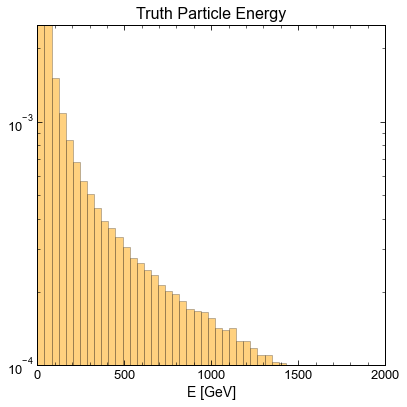

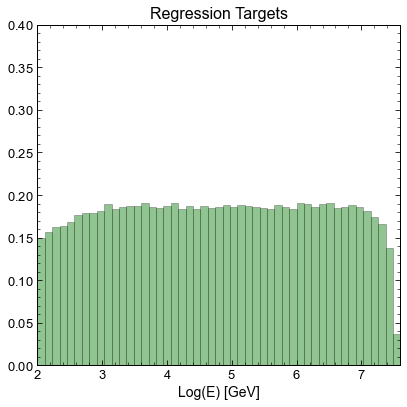

In [7]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[target_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.0001,.0025)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(np.exp(2)), np.log(2000), 50, endpoint=True)
plt.hist(Ylog, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.4)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cell = StandardScaler()
# fit and transform in one step
Y_scal = scaler_e.fit_transform(Ylog.reshape(-1,1))
X_scal = scaler_cell.fit_transform(Xraw[target_zero_mask.reshape(-1)])

In [9]:
X_scal.shape

(544815, 938)

In [10]:
Y_scal.shape

(544815, 1)

In [11]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.models import load_model

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [12]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xraw[target_zero_mask.reshape(-1)],
                                                                    Ylog,
                                                                    test_size=0.15)

In [14]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu


def _q16(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 16)

def _q84(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 84)

def responsePlot(x, y, figfile='', statistic='median',
                 xlabel='True Energy [GeV]', ylabel='Predicted Energy / True Energy',
                 xlim=(0.3,1000), ylim=(0,3), baseline=True,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    
    responseMed = stats.binned_statistic(x, y, bins=xbin, statistic=statistic).statistic
    responseQ16 = stats.binned_statistic(x, y, bins=xbin, statistic=_q16).statistic
    responseQ84 = stats.binned_statistic(x, y, bins=xbin, statistic=_q84).statistic

    responseQ16 = responseMed - responseQ16
    responseQ84 = responseQ84 - responseMed

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
    plt.errorbar(xcenter, responseMed, yerr=[responseQ16,responseQ84], color='red')
    if baseline:
        plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim(xlim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, responseMed


def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))


def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


def histogramSlices(x, ylist, labels=[''], xstep=0.2, statistic='iqr', title = 'Response',
                 xlabel='Predicted Energy / True Energy', ylabel='Clusters', alpha=1.,
                 xlim=(0.3,1000.), ylim=(0.,3.1), binsize=0.05, baseline=False, logscale=False, density=False,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    
    if type(ylist) != type([]):
        ylist = [ylist]

    xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    last_xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    
    ybin = np.arange(ylim[0], ylim[1], binsize)

    plt.cla()
    plt.clf()

    for xbin_left,xbin_right in zip(last_xbin,xbin[1:]):
        fig = plt.figure()
        val_mask = np.logical_and(x > xbin_left, x < xbin_right)

        for y,label in zip(ylist,labels):
            if statistic == 'iqr':
                med = np.median(y[val_mask])
                iqr = np.percentile(y[val_mask], q=84) - np.percentile(y[val_mask], q=16)
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Median = {:.2f}, IQR = {:.2f}'.format(med, iqr),
                         alpha=alpha)
            elif statistic == 'std':
                mu = np.mean(y[val_mask])
                sig = np.std(y[val_mask])
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Mean = {:.2f}, Std. Dev. = {:.2f}'.format(mu, sig),
                         alpha=alpha)
            else:
                plt.hist(y[val_mask], bins=ybin, density=density,
                         label = label,
                         alpha=alpha)
            
            if baseline:
                x1 = np.linspace(-6,6,100)
                pdf = stats.norm.pdf(x1)
                plt.plot(x1, pdf, label='Unit Normal')

        if len(textlist) >= 2:
            textlist[1]['text'] = '{:.4g} - {:.4g} GeV Clusters'.format(xbin_left, xbin_right)
            pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

        if logscale:
            plt.yscale('log')

        # plt.title(title + ' {:.4g} - {:.4g} GeV'.format(xbin_left, xbin_right))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(ylim)
        plt.legend()
        plt.show()

In [15]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 938]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.01, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
_, accuracy = model.evaluate(x_test, y_test)
return accuracy

In [16]:
def DNN(hparams):
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    if True:
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, activation='relu'))
        model.add(Dense(hparams[HP_NUM_UNITS], activation='relu'))
        model.add(Dense(hparams[HP_NUM_UNITS], activation='relu'))
        model.Dropout(hparams[HP_DROPOUT], activation='relu')
        model.add(Dense(units=1, activation='linear'))
        opt = Adam(learning_rate=1e-3, decay=1e-6)
        model.compile(optimizer=hparams[HP_OPTIMIZER], loss='mse', metrics=['mae','mse'])
    return model

In [19]:
import keras.backend as kb
kb.clear_session()

regressor_All = KerasRegressor(build_fn=DNN, batch_size=2500, epochs=500, verbose=1)
print(DNN().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
loadModel = True

In [20]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('dnn_regressor_pfnd.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)
history_baseline_all = regressor_All.fit(X_train, 
                                         y_train,
                                         validation_split = 0.1,
                                         callbacks=[chkpoint, earlystop])

Epoch 1/500
167/167 [==============================] - 2s 12ms/step - loss: 6.2046 - mae: 1.8639 - mse: 6.2046 - val_loss: 3.1075 - val_mae: 1.2983 - val_mse: 3.1075

Epoch 00001: val_loss improved from inf to 3.10755, saving model to dnn_regressor_pfnd.h5
Epoch 2/500
167/167 [==============================] - 2s 10ms/step - loss: 2.5066 - mae: 1.1601 - mse: 2.5066 - val_loss: 2.4365 - val_mae: 1.1230 - val_mse: 2.4365

Epoch 00002: val_loss improved from 3.10755 to 2.43649, saving model to dnn_regressor_pfnd.h5
Epoch 3/500
167/167 [==============================] - 2s 9ms/step - loss: 2.2351 - mae: 1.0736 - mse: 2.2351 - val_loss: 2.1983 - val_mae: 1.0621 - val_mse: 2.1983

Epoch 00003: val_loss improved from 2.43649 to 2.19834, saving model to dnn_regressor_pfnd.h5
Epoch 4/500
167/167 [==============================] - 2s 9ms/step - loss: 2.1171 - mae: 1.0295 - mse: 2.1171 - val_loss: 2.1196 - val_mae: 1.0171 - val_mse: 2.1196

Epoch 00004: val_loss improved from 2.19834 to 2.11958, 

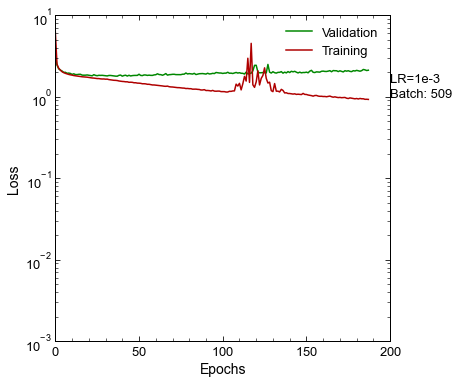

In [21]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_baseline_all.history['val_loss'], label="Validation")
plt.plot(history_baseline_all.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,200)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(200, 1.5, 'LR=1e-3', fontsize=13)
plt.text(200, 1, 'Batch: 509', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_lossCurves_3000batch_LR1e-2_2021-07-016.png', format='png'

In [17]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)
pred = regressor_All.predict(eval_generator(X_scal,1000))

NameError: name 'regressor_All' is not defined

In [23]:
dnn_pred = np.exp(pred).reshape(-1)
y_plot = np.exp(Ylog).reshape(-1)

In [26]:
dnn_pred

array([ 631.8483  ,   17.684353,   11.75669 , ...,   10.472796,
        613.1755  , 1051.1642  ], dtype=float32)

In [27]:
y_plot

array([670.32836914,   3.67780995,   4.88845158, ..., 433.81128514,
       602.20581055, 626.68877983])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 799.992x599.976 with 0 Axes>

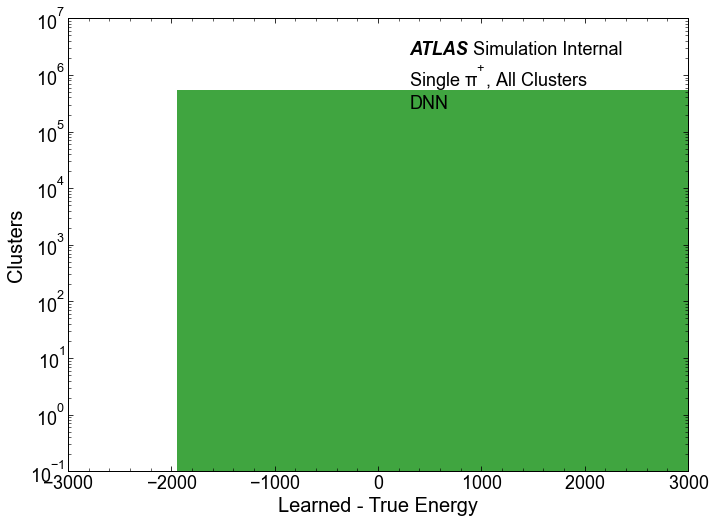

In [25]:
resid_DNN = dnn_pred-y_plot
resid_MDN_mask = np.logical_and(resid_DNN < 2000, resid_DNN > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.75)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.ylabel('Clusters')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'DNN'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

<Figure size 799.992x599.976 with 0 Axes>

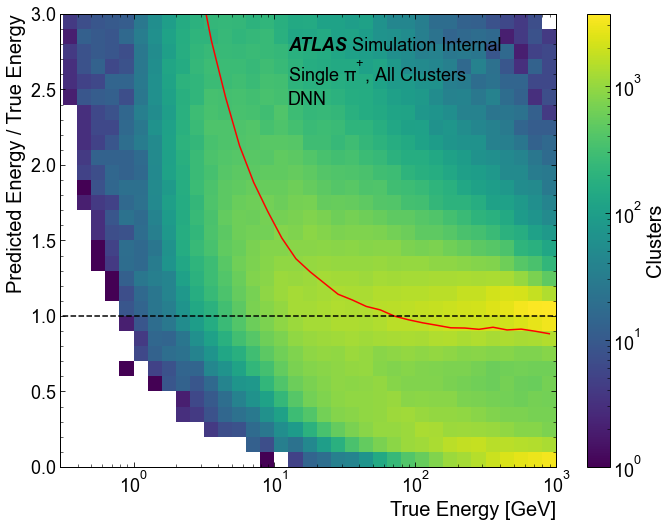

In [24]:
xcenter, medDNN = ru.responsePlot( (y_plot), (dnn_pred/y_plot),  
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'DNN'}])

In [ ]:
xcenter, iqrMDN3 = resolutionPlot(x=y_plot, y=pred/y_plot,
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

In [ ]:
histogramSlices(y_plot, dnn_pred,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'DNN'}])

In [ ]:

xcenter, iqrDNN = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                        pp[pp.test].predict_regressor_DNN_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'DNN'}])

MDN

In [50]:
def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def MDN():
    event_shape = [1]
    num_components = 4
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        # model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, convert_to_tensor_fn=convert_to_tensor))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-3)#, decay=1e-6)

        model.compile(optimizer=opt, loss="mse")
    return model

In [51]:
import keras.backend as kb

kb.clear_session()
regressor_All = KerasRegressor(build_fn=MDN, batch_size=2500, epochs=1000, verbose=1)
print(MDN().summary())

ValueError: `mixture_distribution` components (2) does not equal `components_distribution.batch_shape[-1]` (4)

In [29]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('mdn_regressor_1.h5', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=100, verbose=0, restore_best_weights=True)
history_mdn = regressor_All.fit(X_train, 
                                y_train,
                                validation_split=0.1,
                                callbacks=[chkpoint, earlystop])

Epoch 1/1000
167/167 [==============================] - 6s 20ms/step - loss: 42.5635 - val_loss: 9.0021

Epoch 00001: val_loss improved from inf to 9.00209, saving model to mdn_regressor_1.h5
Epoch 2/1000
167/167 [==============================] - 2s 10ms/step - loss: 8.6214 - val_loss: 9.3575

Epoch 00002: val_loss did not improve from 9.00209
Epoch 3/1000
167/167 [==============================] - 2s 10ms/step - loss: 8.1627 - val_loss: 6.7020

Epoch 00003: val_loss improved from 9.00209 to 6.70202, saving model to mdn_regressor_1.h5
Epoch 4/1000
167/167 [==============================] - 2s 10ms/step - loss: 7.7670 - val_loss: 5.6268

Epoch 00004: val_loss improved from 6.70202 to 5.62684, saving model to mdn_regressor_1.h5
Epoch 5/1000
167/167 [==============================] - 2s 10ms/step - loss: 3.8801 - val_loss: 1.8962

Epoch 00005: val_loss improved from 5.62684 to 1.89624, saving model to mdn_regressor_1.h5
Epoch 6/1000
167/167 [==============================] - 2s 10ms/step

In [49]:
mdn = tf.keras.models.load_model("mdn_regressor_1.h5")

ValueError: Unknown activation function: <lambda>. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [30]:
pred = regressor_All.predict(eval_generator(X_test,200))

410/410 [==============================] - 2s 3ms/step


In [42]:
mdn_pred = np.exp(pred[:,0]).reshape(-1)
y_plot = np.exp(y_test).reshape(-1)

In [45]:
mdn_pred

array([ 39.59385  , 139.65034  ,  12.142118 , ...,  49.8313   ,
        16.653246 ,   5.0155077], dtype=float32)

In [46]:
y_plot

array([ 37.70606995, 114.45298767,  20.52076626, ...,  41.38512802,
         1.24079919,   0.36038172])

In [ ]:
pp['predict_regressor_MDN'] = np.exp(scaler_cal.inverse_transform(pred[:,0].reshape(-1,1)))
pp['predict_regressor_MDN_EoverCalib'] = pp.predict_regressor_MDN / pp.cluster_ENG_CALIB_TOT

In [ ]:
resid_MDN = pp.predict_regressor_MDN-pp.cluster_ENG_CALIB_TOT
resid_MDN_mask = np.logical_and(resid_MDN < 2000, resid_MDN > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_MDN[resid_MDN_mask],bins = n_bins, 
        #  label='Mean = {:.2f}, Std. Dev. = {:.2f}'.format(np.mean(resid_MDN[resid_MDN_mask]),
        #                                                   np.std(resid_MDN[resid_MDN_mask]))
         )
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-2000,2000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'MDN, 1 Component'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

<Figure size 799.992x599.976 with 0 Axes>

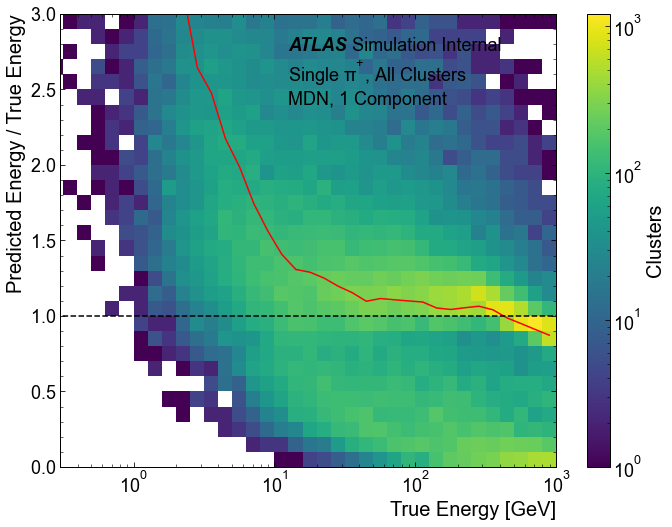

In [47]:
xcenter, medMDN = ru.responsePlot(y_plot, mdn_pred/y_plot,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'MDN, 1 Component'}])

In [ ]:
xcenter, iqrMDN = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                        pp[pp.test].predict_regressor_MDN_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'MDN, 1 Components'}])

In [ ]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'MDN, 1 Component'}])

MDN 3

In [52]:
def MDN_3():
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        # model.add(tfp.layers.MixtureNormal(num_components, event_shape, convert_to_tensor_fn=convert_to_tensor))
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-4)#, decay=1e-6)
        model.compile(optimizer=opt, loss="mse")
    return model

In [54]:
regressor_All = KerasRegressor(build_fn=MDN_3, batch_size=2500, epochs=1000, verbose=1)
print(MDN_3().summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_8 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_9 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 4230      
_________________________________________________________________
mixture_normal_3 (MixtureNor multiple                  0         
Total params: 2,206,185
Trainable params: 2,206,185
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
chkpoint = tf.keras.callbacks.ModelCheckpoint('mdn3_regressor_pfnd.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=150, verbose=0, restore_best_weights=True)
history_mdn3 = regressor_All.fit(X_train, 
                                 y_train,
                                 validation_split=0.1,
                                 callbacks=[chkpoint, earlystop])

Epoch 1/1000
167/167 [==============================] - 7s 22ms/step - loss: 12.2881 - val_loss: 5.7846

Epoch 00001: val_loss improved from inf to 5.78455, saving model to mdn3_regressor_pfnd.h5
Epoch 2/1000
167/167 [==============================] - 2s 11ms/step - loss: 4.6681 - val_loss: 5.4778

Epoch 00002: val_loss improved from 5.78455 to 5.47776, saving model to mdn3_regressor_pfnd.h5
Epoch 3/1000
167/167 [==============================] - 2s 10ms/step - loss: 3.9405 - val_loss: 2.9635

Epoch 00003: val_loss improved from 5.47776 to 2.96353, saving model to mdn3_regressor_pfnd.h5
Epoch 4/1000
167/167 [==============================] - 2s 10ms/step - loss: 2.7890 - val_loss: 2.4205

Epoch 00004: val_loss improved from 2.96353 to 2.42055, saving model to mdn3_regressor_pfnd.h5
Epoch 5/1000
167/167 [==============================] - 2s 10ms/step - loss: 3.3657 - val_loss: 2.5787

Epoch 00005: val_loss did not improve from 2.42055
Epoch 6/1000
167/167 [==============================

In [ ]:
pred = regressor_All.predict(eval_generator(All_input,300))
pp['predict_regressor_MDN3'] = np.exp(scaler_cal.inverse_transform(pred[:,0].reshape(-1,1)))
pp['predict_regressor_MDN3_EoverCalib'] = pp.predict_regressor_MDN3 / pp.cluster_ENG_CALIB_TOT

In [ ]:
resid_MDN3 = pp.predict_regressor_MDN3-pp.cluster_ENG_CALIB_TOT
resid_MDN3_mask = np.logical_and(resid_MDN3 < 2000, resid_MDN3 > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_MDN3[resid_MDN3_mask],bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-2000,2000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [ ]:
xcenter, iqrMDN3 = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                        pp[pp.test].predict_regressor_MDN3_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'MDN, 3 Components'}])

In [ ]:
xcenter, medMDN3 = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN3_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'MDN, 3 Components'}])

In [ ]:
histogramSlices(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN3_EoverCalib,
                atlas_x = 0.55, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.7, 'text': ''},
                            {'x': 0.55, 'y': 0.65,  'text': 'MDN, 3 Components'}])

In [ ]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_DNN,bins = n_bins,alpha=0.5, label='DNN')
plt.hist(resid_MDN[resid_MDN_mask],bins = n_bins,alpha=0.5, label='MDN w/ 1 Component')
plt.hist(resid_MDN3[resid_MDN3_mask],bins = n_bins,alpha=0.5, label='MDN w/ 3 Components')
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-3000,3000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.8
simulation = True
textlist = [{'x': 0.55, 'y': 0.7, 'text': 'Single $\pi^{+}$, All Clusters'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [medDNN, medMDN, medMDN3],
                                labels = ['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response Median',
                figfile = plotpath + "hist_2D_E_vs_ratio_pp_profile_Overlay_Overlay_BaseLCAll.pdf",
                x_min = 0.3, y_min=0.75, y_max = 1.25,
                extra_lines = [[[0.1,1000],[1,1]]],
                # linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                atlas_x = 0.5, atlas_y = 0.275, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.175, 'text': 'Single $\pi^{+}$, All Clusters'}])

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, 
                ylist=[pp.predict_regressor_DNN_EoverCalib, 
                       pp.predict_regressor_MDN_EoverCalib, 
                       pp.predict_regressor_MDN3_EoverCalib],
                labels=['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                binsize=0.02, xstep=0.2, alpha=0.8,
                atlas_x = 0.55, atlas_y = 0.8, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.7, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.55, 'y': 0.65, 'text': ''}])

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrDNN, iqrMDN, iqrMDN3],
                labels = ['DNN', 'MDN w/ 1 Component', 'MDN w/ 3 Components'],
                xlabel = 'True Energy [GeV]', ylabel = 'Response IQR / (2 x Median)',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = .75,
                atlas_x = 0.56, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.56, 'y': 0.65, 'text': 'Single $\pi^{+}$, All Clusters'}])

In [ ]:
median = pred[:,0]
sigma = pred[:,1]

# Renormalize data (inverse transform scaler normalization); propogate uncertainties
median = scaler_cal.scale_ * median
sigma = scaler_cal.scale_ * sigma # or _median * (sigma / median)

median = median + scaler_cal.mean_

median = np.exp(median)   # Reconstructed Energy Per Cluster
sigma = median * sigma   # Reconstructed Energy Uncertainty (Std dev) Per Cluster


# Calculate pull
pull = (median-pp.cluster_ENG_CALIB_TOT) / sigma
badval_mask = np.logical_and(pull < 100, pull > -100)
pull = pull[badval_mask]

In [ ]:
# Plot pull
n_bins = 1000
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))
plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Clusters')
plt.xlim(-6,6)
plt.legend()

atlas_x = 0.58
atlas_y = 0.85
simulation = True
textlist = [{'x': 0.58, 'y': 0.75, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.58, 'y': 0.7, 'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [ ]:
# Plot pull
n_bins = 1000
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pull,bins = n_bins, density = True, label='All Clusters, Mean = {:.3f}, Std. dev. = {:.3f}'.format(pull.mean(), pull.std()))

x = np.linspace(-6,6,100)
pdf = stats.norm.pdf(x)
plt.plot(x, pdf, label='Unit Normal')

plt.xlabel('(Predicted Energy - True Energy) / Predicted Uncertainty')
plt.ylabel('Probability Density')
plt.xlim(-6,6)
plt.yscale('log')
plt.legend()

atlas_x = 0.3
atlas_y = 0.25
simulation = True
textlist = [{'x': 0.3, 'y': 0.15, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.3, 'y': 0.1, 'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, pull, statistic='std',
                ylim=(-6., 6.), xstep=1.3333333333333, binsize=0.1, 
                xlabel='Pull', ylabel='Clusters', title='Pull',
                atlas_x = 0.58, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.58, 'y': 0.75, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.58, 'y': 0.7, 'text': ''},
                            {'x': 0.58, 'y': 0.65, 'text': 'MDN, 3 Components'}])

In [ ]:
histogramSlices(pp.cluster_ENG_CALIB_TOT, pull, statistic='std',
                ylim=(-6., 6.), xstep=1.3333333333333, binsize=0.1, baseline=True, logscale=True, density=True,
                xlabel='Pull', ylabel='Probability Density', title='Pull',
                atlas_x = 0.3, atlas_y = 0.4, simulation = True,
                textlist = [{'x': 0.3, 'y': 0.3, 'text': 'Single $\pi^{+}$'},
                            {'x': 0.3, 'y': 0.25, 'text': ''},
                            {'x': 0.3, 'y': 0.2, 'text': 'MDN, 3 Components'}])

In [ ]:
median_over_true = median / pp.cluster_ENG_CALIB_TOT   #   Reconstructed Energy / True Energy
iqr_over_median = 2 * sigma / median  # Reconstructed Energy Resolution Per Cluster
iqr_over_true = 2 * sigma / pp.cluster_ENG_CALIB_TOT  # Pred Sigma / True Energy Per Cluster

In [ ]:
xcenter, iqrOverMed_MDN_learned = ru.responsePlot(pp.cluster_ENG_CALIB_TOT, iqr_over_median/2,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x Predicted Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])

xcenter, iqrOverTrue_MDN_learned = ru.responsePlot(pp.cluster_ENG_CALIB_TOT, iqr_over_true/2,
                 plotpath+'hist_2D_calib_vs_sigma.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 xlim=(0.3,1000), ylim=(0,0.75), baseline=False,
                 xlabel='True Energy [GeV]', ylabel='Predicted IQR / (2 x True Energy)',
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'MDN, 3 Components'}])

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrMDN3, iqrOverMed_MDN_learned],
                labels = ['Response IQR / (2 x Response Median)', 'Median Predicted IQR / (2 x Predicted Energy)'],
                xlabel = 'True Energy [GeV]', ylabel = 'Resolution',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegLCEMB1TileBar0E1T0All.pdf",
                x_min = 0.3, y_max = 0.75,
                linestyles = ['dashed', 'solid', 'solid'], colorgrouping=1,
                atlas_x = 0.55, atlas_y = 0.75, simulation = True,
                textlist = [{'x': 0.55, 'y': 0.65, 'text': 'Single $\pi^{+}$, All Clusters'}])

In [ ]:
def convert_to_tensor(X):
    # return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)
    # return X.sample(100)
    return X.prob(np.linspace(-3,3,100))

def MDN3():
    event_shape = [1]
    num_components = 3
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    with strategy.scope():    
        model = Sequential()
        features = number_pixels + 2
        model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
        model.add(Dense(features, activation='relu'))
        model.add(Dense(int(features/2), activation='relu'))
        model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
        
        model.add(tfp.layers.MixtureNormal(num_components, event_shape, #validate_args=True,
                                           convert_to_tensor_fn=convert_to_tensor))

        opt = Adam(learning_rate=1e-4)#, decay=1e-6)
        model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [ ]:
regressor_All = MDN3()
regressor_All.load_weights(modelpath + 'mdn3_regressor.h5')

In [ ]:
test = regressor_All(All_input)

t1 = test.sample(10).numpy().reshape(-1)
t1 = t1[np.logical_and(t1 < 3, t1 > -3)]

plt.hist(pp[pp.train].s_logECalib.to_numpy(), bins=100, alpha=0.3, density=True, label='All Clusters')
plt.hist(t1, bins=100, alpha=0.3, density=True, label='MDN Sampled Distribution')
# plt.yscale('log')
plt.title("Log Normalized Energy")
plt.xlabel('Log Normalized Truth Energy')
plt.ylabel('Probability Density')
plt.legend()
plt.show()